In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

In [3]:
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 256
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 100
latent_dim = 4
hidden_dim = 512


In [4]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [5]:
# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/',
    download=True,
    train=True,
    transform=transform,
)
len(train_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11507910.84it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 350019.20it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3150090.50it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4827807.59it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



60000

In [6]:
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/',
    download=True,
    train=False,
    transform=transform,
)


In [7]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

In [12]:
@dataclass
class VAEOutput:

    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor

    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

Modifying Depth part on the top of another VAEs model code to shoe the result of changing depth in VAEs architecture

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAEOutput:

    def __init__(self, z_dist, z_sample, x_recon, loss, loss_recon, loss_kl):
        self.z_dist = z_dist
        self.z_sample = z_sample
        self.x_recon = x_recon
        self.loss = loss
        self.loss_recon = loss_recon
        self.loss_kl = loss_kl

class VAE(nn.Module):


    def __init__(self, input_dim, hidden_dim, latent_dim, depth):
        super(VAE, self).__init__()

        encoder_layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
        ]
        for _ in range(depth):
            encoder_layers.extend([
                nn.Linear(hidden_dim // (2 ** _), hidden_dim // (2 ** (_ + 1))),
                nn.SiLU(),  # Swish activation function
            ])
        encoder_layers.extend([
            nn.Linear(hidden_dim // (2 ** depth), 2 * latent_dim),  # 2 for mean and variance
        ])

        decoder_layers = [
            nn.Linear(latent_dim, hidden_dim // (2 ** depth)),
            nn.SiLU(),  # Swish activation function
        ]
        for _ in range(depth):
            decoder_layers.extend([
                nn.Linear(hidden_dim // (2 ** (depth - _)), hidden_dim // (2 ** (depth - _ - 1))),
                nn.SiLU(),  # Swish activation function
            ])
        decoder_layers.extend([
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        ])

        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

        self.softplus = nn.Softplus()

    def encode(self, x, eps: float = 1e-8):

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):

        return dist.rsample()

    def decode(self, z):

        return self.decoder(z)

    def forward(self, x, compute_loss: bool = True):

        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )

        # compute loss terms
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon + loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )


incresing the depth once

In [10]:
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim,depth=8).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#print(f'Number of parameters: {num_params:,}')

model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): SiLU()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): SiLU()
    (12): Linear(in_features=16, out_features=8, bias=True)
    (13): SiLU()
    (14): Linear(in_features=8, out_features=4, bias=True)
    (15): SiLU()
    (16): Linear(in_features=4, out_features=2, bias=True)
    (17): SiLU()
    (18): Linear(in_features=2, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2, out_features=4, bias=True)
    (3): SiLU()
    (4): Linear(in_features=4, out_featu

In [ ]:
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
def train(model, dataloader, optimizer, prev_updates, writer=None):

    model.train()  # Set the model to training mode

    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)

        optimizer.zero_grad()  # Zero the gradients

        output = model(data)  # Forward pass
        loss = output.loss

        loss.backward()

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            #print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

In [ ]:
bce_losses = []
kld_losses = []

def test(model, dataloader, cur_step, writer=None):

    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    # Append losses to the lists
    bce_losses.append(test_recon_loss)
    kld_losses.append(test_kl_loss)

    if writer is not None:

        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)

        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)

        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [ ]:
prev_updates = 0
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 188.1867 (BCE: 186.0214, KLD: 2.1653)
Epoch 2/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 183.5293 (BCE: 181.2610, KLD: 2.2683)
Epoch 3/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 178.7059 (BCE: 176.0498, KLD: 2.6561)
Epoch 4/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 177.3217 (BCE: 174.5634, KLD: 2.7584)
Epoch 5/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.1109 (BCE: 168.8396, KLD: 3.2713)
Epoch 6/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.3215 (BCE: 168.0721, KLD: 3.2494)
Epoch 7/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.6077 (BCE: 168.0274, KLD: 3.5803)
Epoch 8/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.1810 (BCE: 167.6912, KLD: 3.4898)
Epoch 9/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.7361 (BCE: 164.3344, KLD: 3.4017)
Epoch 10/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.8466 (BCE: 166.1566, KLD: 3.6900)
Epoch 11/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.5084 (BCE: 163.9272, KLD: 3.5812)
Epoch 12/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 174.4931 (BCE: 170.6824, KLD: 3.8108)
Epoch 13/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.0150 (BCE: 163.3292, KLD: 3.6858)
Epoch 14/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 176.0543 (BCE: 172.4257, KLD: 3.6286)
Epoch 15/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 178.9042 (BCE: 175.4958, KLD: 3.4084)
Epoch 16/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.9041 (BCE: 168.1614, KLD: 3.7427)
Epoch 17/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.4464 (BCE: 166.9551, KLD: 3.4913)
Epoch 18/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.8286 (BCE: 164.2607, KLD: 3.5678)
Epoch 19/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.1306 (BCE: 166.3819, KLD: 3.7486)
Epoch 20/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.1228 (BCE: 166.2630, KLD: 3.8598)
Epoch 21/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.5822 (BCE: 168.8557, KLD: 3.7266)
Epoch 22/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.1774 (BCE: 163.6073, KLD: 3.5701)
Epoch 23/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 163.9337 (BCE: 160.0828, KLD: 3.8509)
Epoch 24/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 174.3327 (BCE: 170.7981, KLD: 3.5345)
Epoch 25/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.8204 (BCE: 165.0606, KLD: 3.7598)
Epoch 26/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 164.8825 (BCE: 161.0692, KLD: 3.8132)
Epoch 27/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 163.3219 (BCE: 159.3705, KLD: 3.9514)
Epoch 28/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.9733 (BCE: 170.4024, KLD: 3.5709)
Epoch 29/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.5212 (BCE: 164.9798, KLD: 3.5414)
Epoch 30/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.8606 (BCE: 163.1906, KLD: 3.6700)
Epoch 31/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.4442 (BCE: 163.5006, KLD: 3.9436)
Epoch 32/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 165.7609 (BCE: 161.8000, KLD: 3.9609)
Epoch 33/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.8778 (BCE: 164.1718, KLD: 3.7060)
Epoch 34/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.1710 (BCE: 168.6321, KLD: 3.5389)
Epoch 35/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.8440 (BCE: 166.1239, KLD: 3.7201)
Epoch 36/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.8430 (BCE: 166.2013, KLD: 3.6417)
Epoch 37/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.8625 (BCE: 165.0085, KLD: 3.8540)
Epoch 38/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.4079 (BCE: 163.5747, KLD: 3.8332)
Epoch 39/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.2913 (BCE: 162.4618, KLD: 3.8295)
Epoch 40/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.7028 (BCE: 163.8819, KLD: 3.8209)
Epoch 41/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 164.9121 (BCE: 161.0054, KLD: 3.9067)
Epoch 42/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 182.4358 (BCE: 178.5479, KLD: 3.8879)
Epoch 43/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.5122 (BCE: 168.9529, KLD: 3.5593)
Epoch 44/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 174.3572 (BCE: 170.8447, KLD: 3.5124)
Epoch 45/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.1269 (BCE: 167.4324, KLD: 3.6944)
Epoch 46/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.0028 (BCE: 165.3082, KLD: 3.6946)
Epoch 47/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.0748 (BCE: 166.4012, KLD: 3.6736)
Epoch 48/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.0448 (BCE: 164.2073, KLD: 3.8375)
Epoch 49/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.4246 (BCE: 163.5911, KLD: 3.8335)
Epoch 50/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 165.6508 (BCE: 161.7318, KLD: 3.9190)
Epoch 51/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.5234 (BCE: 164.6605, KLD: 3.8629)
Epoch 52/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.1374 (BCE: 163.0606, KLD: 4.0768)
Epoch 53/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.2593 (BCE: 163.2256, KLD: 4.0337)
Epoch 54/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 184.3799 (BCE: 180.1295, KLD: 4.2504)
Epoch 55/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 177.3908 (BCE: 172.9444, KLD: 4.4463)
Epoch 56/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.3331 (BCE: 168.4968, KLD: 4.8364)
Epoch 57/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.0465 (BCE: 168.5435, KLD: 4.5030)
Epoch 58/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.9750 (BCE: 168.5605, KLD: 4.4145)
Epoch 59/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.6874 (BCE: 167.0885, KLD: 4.5989)
Epoch 60/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.0442 (BCE: 161.3714, KLD: 4.6728)
Epoch 61/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.2436 (BCE: 161.5704, KLD: 4.6732)
Epoch 62/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 165.4090 (BCE: 160.7311, KLD: 4.6780)
Epoch 63/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 175.8517 (BCE: 170.7766, KLD: 5.0751)
Epoch 64/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.7203 (BCE: 167.9883, KLD: 4.7320)
Epoch 65/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 175.3390 (BCE: 170.7621, KLD: 4.5768)
Epoch 66/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.0897 (BCE: 164.5841, KLD: 4.5056)
Epoch 67/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 182.3005 (BCE: 178.1514, KLD: 4.1490)
Epoch 68/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 177.5873 (BCE: 173.2690, KLD: 4.3183)
Epoch 69/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.7596 (BCE: 168.4449, KLD: 4.3147)
Epoch 70/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.4165 (BCE: 169.0596, KLD: 4.3568)
Epoch 71/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.7861 (BCE: 165.3570, KLD: 4.4291)
Epoch 72/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.3214 (BCE: 168.0458, KLD: 4.2756)
Epoch 73/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.1596 (BCE: 164.8128, KLD: 4.3468)
Epoch 74/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.7610 (BCE: 166.3349, KLD: 4.4261)
Epoch 75/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.1392 (BCE: 166.6962, KLD: 4.4431)
Epoch 76/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.5483 (BCE: 164.2065, KLD: 4.3418)
Epoch 77/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.9995 (BCE: 169.2766, KLD: 4.7229)
Epoch 78/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.7700 (BCE: 166.0084, KLD: 4.7615)
Epoch 79/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 179.5299 (BCE: 175.1320, KLD: 4.3978)
Epoch 80/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 180.3223 (BCE: 176.0069, KLD: 4.3155)
Epoch 81/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 178.5803 (BCE: 174.1107, KLD: 4.4696)
Epoch 82/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 181.8020 (BCE: 176.9893, KLD: 4.8126)
Epoch 83/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 175.0009 (BCE: 170.8117, KLD: 4.1892)
Epoch 84/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.9289 (BCE: 166.6461, KLD: 4.2828)
Epoch 85/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.8420 (BCE: 165.6251, KLD: 4.2170)
Epoch 86/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 174.6389 (BCE: 170.4235, KLD: 4.2154)
Epoch 87/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.9295 (BCE: 163.4971, KLD: 4.4324)
Epoch 88/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.1294 (BCE: 164.8989, KLD: 4.2305)
Epoch 89/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.8572 (BCE: 162.4341, KLD: 4.4231)
Epoch 90/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.3261 (BCE: 165.9892, KLD: 4.3369)
Epoch 91/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 195.1023 (BCE: 191.1004, KLD: 4.0019)
Epoch 92/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.4438 (BCE: 167.3240, KLD: 4.1199)
Epoch 93/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.0105 (BCE: 166.8438, KLD: 4.1666)
Epoch 94/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 176.1365 (BCE: 171.9702, KLD: 4.1663)
Epoch 95/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 174.9327 (BCE: 170.7348, KLD: 4.1980)
Epoch 96/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.6569 (BCE: 169.6329, KLD: 4.0240)
Epoch 97/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 175.3392 (BCE: 171.3544, KLD: 3.9848)
Epoch 98/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.6560 (BCE: 165.7547, KLD: 3.9013)
Epoch 99/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.4246 (BCE: 165.3607, KLD: 4.0639)
Epoch 100/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.0014 (BCE: 163.9791, KLD: 4.0224)


depth 6 epoch 100

In [ ]:
print("BCE_losses")
print(bce_losses)
print("KDL losses")
print(kld_losses)

BCE_losses
[186.0213650087767, 181.2610348085814, 176.04980449435078, 174.56336781948428, 168.83959169025664, 168.07209932351415, 168.0273748470258, 167.6911883776701, 164.33439771434928, 166.15656869622725, 163.92723566369165, 170.68235604974288, 163.32921397535108, 172.42572639561908, 175.49580499190319, 168.16137791887115, 166.95514186424546, 164.26073446153086, 166.3819236272498, 166.2629925691629, 168.85566730740703, 163.60726233373714, 160.0828305015081, 170.7981273795985, 165.06058762948723, 161.0692488271979, 159.3704665944546, 170.4023835387411, 164.97980760019036, 163.19062573396707, 163.50058466271508, 161.79995283295835, 164.17183984684038, 168.6320806575727, 166.1238650551325, 166.2013182821153, 165.00845163079757, 163.57468153555183, 162.46180396743966, 163.8818797823749, 161.00544642194916, 178.5479276632961, 168.95289689076097, 170.84471999542623, 167.43244161485117, 165.30819335164904, 166.40118292313588, 164.20727191393888, 163.59112065955054, 161.73181789736205, 164.

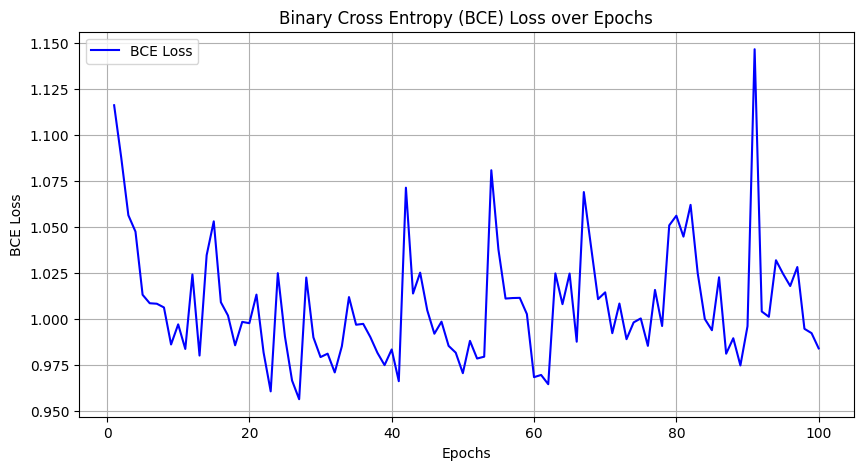

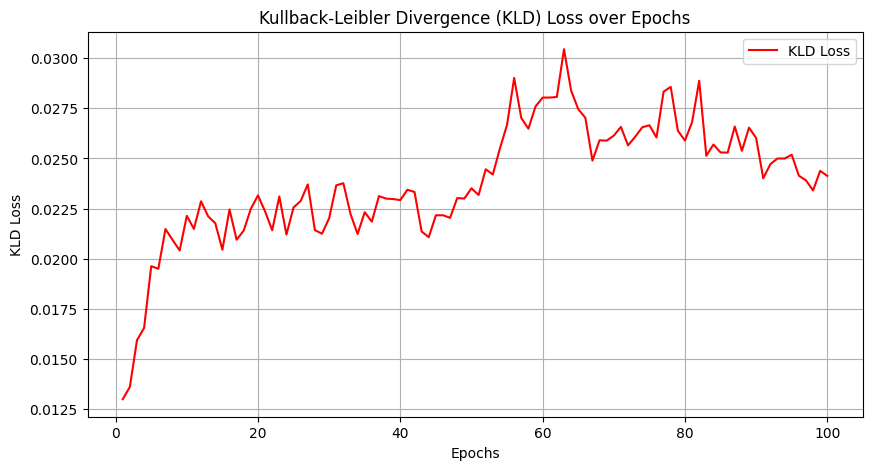

In [ ]:
import matplotlib.pyplot as plt

# BCE and KLD losses from the training
bce_losses6=[186.0213650087767, 181.2610348085814, 176.04980449435078, 174.56336781948428, 168.83959169025664, 168.07209932351415, 168.0273748470258, 167.6911883776701, 164.33439771434928, 166.15656869622725, 163.92723566369165, 170.68235604974288, 163.32921397535108, 172.42572639561908, 175.49580499190319, 168.16137791887115, 166.95514186424546, 164.26073446153086, 166.3819236272498, 166.2629925691629, 168.85566730740703, 163.60726233373714, 160.0828305015081, 170.7981273795985, 165.06058762948723, 161.0692488271979, 159.3704665944546, 170.4023835387411, 164.97980760019036, 163.19062573396707, 163.50058466271508, 161.79995283295835, 164.17183984684038, 168.6320806575727, 166.1238650551325, 166.2013182821153, 165.00845163079757, 163.57468153555183, 162.46180396743966, 163.8818797823749, 161.00544642194916, 178.5479276632961, 168.95289689076097, 170.84471999542623, 167.43244161485117, 165.30819335164904, 166.40118292313588, 164.20727191393888, 163.59112065955054, 161.73181789736205, 164.66051318977452, 163.0606028882763, 163.2255811087693, 180.12953359869462, 172.9444363750989, 168.49675219572043, 168.54351149933248, 168.56052910527097, 167.0884685274921, 161.37137787251532, 161.57039999660057, 160.7310615249827, 170.7766159637065, 167.98834518239468, 170.76214560979528, 164.5840539087223, 178.15141122552413, 173.26899487459207, 168.44494107403332, 169.0596377215808, 165.35698574404174, 168.04582310930084, 164.8127590131156, 166.33494065683098, 166.69616351550138, 164.2065215291856, 169.27655686004252, 166.00841995432407, 175.13203913048852, 176.00687765773338, 174.11072472680974, 176.98934105981755, 170.81171001965487, 166.6460851355444, 165.6250855651083, 170.42352584645718, 163.49710990809186, 164.89888618565814, 162.43411390087272, 165.98921937580351, 191.10036033920096, 167.32395413555676, 166.84383344046677, 171.97021638894384, 170.73476516144186, 169.63290637052512, 171.35439657863182, 165.75469507144976, 165.36068377917326, 163.9790632030632]

kld_losses6= [2.165331660946713, 2.2682991631423373, 2.6560601071466374, 2.758365012422393, 3.2713274231439904, 3.249447961396809, 3.580298680293409, 3.4898447628262677, 3.401690528362612, 3.69002040730247, 3.581174874607521, 3.8107738223256944, 3.6857777064359643, 3.6285855347597145, 3.408366864240622, 3.742733113373382, 3.491253237181072, 3.567831078662148, 3.7486469956892954, 3.859801576107363, 3.726570005658307, 3.5701480877550344, 3.8508585434925706, 3.534528699102281, 3.7597976032691665, 3.813209675535371, 3.951413130458397, 3.570893848998637, 3.5413944087451017, 3.66997638533387, 3.94360710699347, 3.9609323362760906, 3.7059704231310495, 3.538891913015631, 3.720109894305845, 3.641703171066091, 3.854009999504572, 3.833214922796322, 3.8294804669633695, 3.820891217340397, 3.906683589838728, 3.8878801382040677, 3.55928765369367, 3.5124478823021996, 3.6944174585463125, 3.694585434998138, 3.6735726760912546, 3.8375397724441336, 3.8335286997541598, 3.918999620630771, 3.862927608852145, 4.0767541746549965, 4.03369731842717, 4.250410484362252, 4.446321976335743, 4.836389958104001, 4.502978886230083, 4.414450174645532, 4.598942617826824, 4.672783918018583, 4.673193213305896, 4.677961687498454, 5.075092357925222, 4.731971505322034, 4.576813202870043, 4.5056348028062265, 4.149046816403353, 4.3182934899873375, 4.314668272115007, 4.3568259432346, 4.429074190839937, 4.275551219529744, 4.346798371665085, 4.4261010447634925, 4.443080322651923, 4.341760230969779, 4.722931258286102, 4.761533187914498, 4.3978408922123, 4.315457042259506, 4.4695783566825, 4.812637679184539, 4.189188914962962, 4.282812927342668, 4.216958178749567, 4.2153537907177885, 4.4324057132382935, 4.230475045457671, 4.423109434827974, 4.336882367918763, 4.001946935170813, 4.119887502887581, 4.16662014587016, 4.166312338430671, 4.19798074794721, 4.023956389366826, 3.9848116711725163, 3.9013376235961914, 4.063926920106139, 4.022352088855792]


bce_losses6_multiplied = [x * 0.006 for x in bce_losses6]
kld_losses6_multiplied = [x * 0.006 for x in kld_losses6]

epochs = range(1, len(bce_losses6_multiplied) + 1)

# Plotting BCE loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, bce_losses6_multiplied, label='BCE Loss', color='blue')
plt.title('Binary Cross Entropy (BCE) Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)
plt.show()
epochs = range(1, len(kld_losses6_multiplied) + 1)

# Plotting KLD loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, kld_losses6_multiplied, label='KLD Loss', color='red')
plt.title('Kullback-Leibler Divergence (KLD) Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('KLD Loss')
plt.legend()
plt.grid(True)
plt.show()

depth 3 epoch 100

In [ ]:
print("BCE_losses")
print(bce_losses)
print("KDL losses")
print(kld_losses)

BCE_losses
[164.54211445096172, 151.71646291998368, 144.60490050496935, 142.25407033026974, 138.60184189035922, 139.37467280520667, 139.12734454191184, 136.15297863151454, 138.84831701351118, 135.0360592226439, 138.48864456369907, 136.73646342603467, 137.46007402637338, 135.1526405237898, 133.49529961694645, 133.0129537461679, 134.68004376375222, 135.13741331462617, 133.75406859192668, 136.46452534349658, 133.68674816662752, 132.80004380624504, 135.22779073594492, 133.56445418732076, 134.64944824991346, 138.11128341095358, 131.04234932042377, 133.22203199169303, 132.2809519707402, 132.24731145931196, 130.7356354918661, 131.5131931546368, 132.51319006424916, 132.23643860635877, 133.05553687373293, 131.59737743908846, 131.216091494017, 132.57584921921355, 131.28081811832476, 130.90201819697512, 131.7256088256836, 129.99005059350895, 130.37323828588558, 131.2594026975994, 130.67222817336457, 131.33189353459997, 131.74760127972954, 131.0254715545268, 130.49517484254474, 133.4765441508233, 

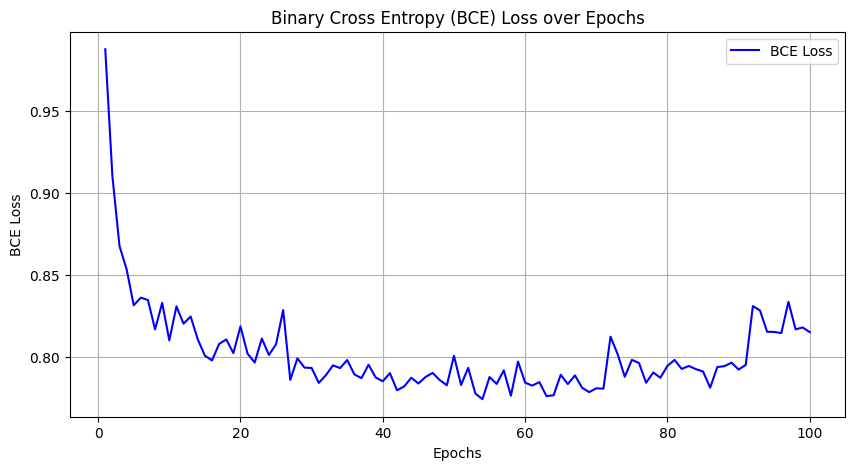

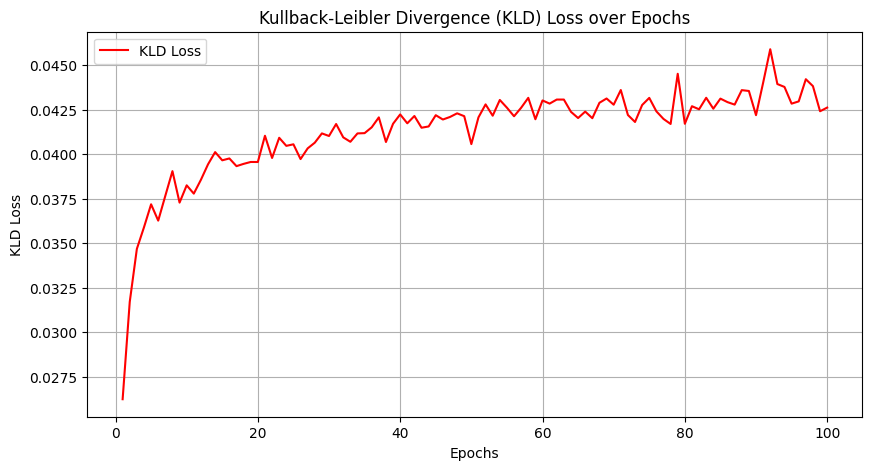

In [ ]:
import matplotlib.pyplot as plt

# BCE and KLD losses from the training
bce_losses3=[164.54211445096172, 151.71646291998368, 144.60490050496935, 142.25407033026974, 138.60184189035922, 139.37467280520667, 139.12734454191184, 136.15297863151454, 138.84831701351118, 135.0360592226439, 138.48864456369907, 136.73646342603467, 137.46007402637338, 135.1526405237898, 133.49529961694645, 133.0129537461679, 134.68004376375222, 135.13741331462617, 133.75406859192668, 136.46452534349658, 133.68674816662752, 132.80004380624504, 135.22779073594492, 133.56445418732076, 134.64944824991346, 138.11128341095358, 131.04234932042377, 133.22203199169303, 132.2809519707402, 132.24731145931196, 130.7356354918661, 131.5131931546368, 132.51319006424916, 132.23643860635877, 133.05553687373293, 131.59737743908846, 131.216091494017, 132.57584921921355, 131.28081811832476, 130.90201819697512, 131.7256088256836, 129.99005059350895, 130.37323828588558, 131.2594026975994, 130.67222817336457, 131.33189353459997, 131.74760127972954, 131.0254715545268, 130.49517484254474, 133.4765441508233, 130.5248471030706, 132.26065971277936, 129.66710971880562, 129.0809088598324, 131.32495030270348, 130.62892334370673, 132.00901321217984, 129.43345989758456, 132.89952357811265, 130.76264692861824, 130.4582345696944, 130.81610966935943, 129.39391423478912, 129.4817702860772, 131.56026574629772, 130.61620910258233, 131.4950449496885, 130.24647724779345, 129.80044584636445, 130.1827923738504, 130.1509915122503, 135.414863779575, 133.64490335198897, 131.35556802870352, 133.07233564159537, 132.74542023863972, 130.75102224229258, 131.7902871626842, 131.25440109832377, 132.46531397179712, 133.05910124959826, 132.14946621279174, 132.44841602180577, 132.12655678278284, 131.88945596429366, 130.250760718237, 132.336557991897, 132.432147931449, 132.779402044755, 132.08838402470457, 132.55762510661836, 138.521597560448, 138.07532636425162, 135.9178143271917, 135.89804222010358, 135.78475807286517, 138.94807192645496, 136.16124155551572, 136.35134018523783, 135.8769436606878]
kld_losses3= [4.372280775746213, 5.284106713307055, 5.780639298354523, 5.982540631596046, 6.197980760019036, 6.0450269481803796, 6.277811672114119, 6.508452180065686, 6.213811476019364, 6.3756278074240385, 6.298026851460904, 6.4274457436573655, 6.572437165658685, 6.686666114420831, 6.609947965114931, 6.627451111998739, 6.555364168142971, 6.576635288286813, 6.594437719900397, 6.594196416154692, 6.839847130111501, 6.6319370631930195, 6.820940597147882, 6.745390584197225, 6.759815735153005, 6.621529035930392, 6.7217234478721135, 6.774968135206005, 6.861988707433773, 6.837734300878983, 6.94993293134472, 6.82491650158846, 6.783493162710456, 6.861819719966454, 6.864446815056137, 6.919013011304638, 7.0120586081396175, 6.78150944770137, 6.952314322507834, 7.039784298667425, 6.956658677209782, 7.02513563783863, 6.91515690163721, 6.926978920079485, 7.032472574258152, 6.992078183572503, 7.015969083278994, 7.0498764907257465, 7.02319275578366, 6.761673504793191, 7.012230160870129, 7.133657594270344, 7.02769719498067, 7.175173004971275, 7.102762614624409, 7.022569716731204, 7.1024134611781635, 7.195161656488346, 6.994611993620667, 7.170611472069463, 7.14104602306704, 7.178985191296928, 7.178921053681193, 7.06386855282361, 7.005888733682753, 7.0661863435672805, 7.004431513291371, 7.148729034616977, 7.188865685764747, 7.130683627309678, 7.268240494064138, 7.034334943264345, 6.969010165975064, 7.12777040578142, 7.1945627128021625, 7.068684070925169, 6.997452102129972, 6.950368899333326, 7.420229640188096, 6.952033145518243, 7.116563688350629, 7.087646774098843, 7.195623554760897, 7.093530316896077, 7.187691966189614, 7.154704142220413, 7.131660382958907, 7.267227776442902, 7.259313118608692, 7.032770168932179, 7.336068117165867, 7.65040296240698, 7.324287776705585, 7.297175739384905, 7.140660219554659, 7.16174899475484, 7.369514417044724, 7.304629247399825, 7.0693907315218, 7.1038102137891554]

bce_losses3_multiplied = [x * 0.006 for x in bce_losses3]
kld_losses3_multiplied = [x * 0.006 for x in kld_losses3]

epochs = range(1, len(bce_losses3_multiplied) + 1)

# Plotting BCE loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, bce_losses3_multiplied, label='BCE Loss', color='blue')
plt.title('Binary Cross Entropy (BCE) Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)
plt.show()
epochs = range(1, len(kld_losses3_multiplied) + 1)

# Plotting KLD loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, kld_losses3_multiplied, label='KLD Loss', color='red')
plt.title('Kullback-Leibler Divergence (KLD) Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('KLD Loss')
plt.legend()
plt.grid(True)
plt.show()

depth 4, epoch 100

In [ ]:
print("BCE_losses")
print(bce_losses)
print("KDL losses")
print(kld_losses)

BCE_losses
[182.4171824394902, 161.65865683253807, 156.75273769716674, 153.54550344732743, 147.766551729999, 143.37243304675138, 143.0461014373393, 142.50531469417524, 145.99679275705844, 145.01881003078026, 140.98534702349312, 139.8774893072587, 140.11308810077136, 138.61170727693582, 139.14379670348347, 137.52518067178846, 137.5922297224214, 137.25483162795442, 135.79372299773783, 141.08177803136127, 138.9526987196524, 137.67626953125, 136.11271841314775, 135.91511352152764, 134.7895691304267, 135.4300727361365, 133.9635460769074, 136.2463534391379, 137.69474956657314, 135.59987543806244, 133.90685928924174, 134.78141707408278, 138.71514554566974, 134.61999898017208, 144.65732796584504, 135.38696163515502, 134.67969377734994, 135.2386752744264, 134.09950352922272, 134.36568779281424, 136.81479586830622, 136.99872733973248, 142.12733903715883, 133.6551157311548, 137.5085132454015, 138.9168748493436, 138.75599960134, 139.31029964398735, 139.01857583734053, 140.60101337674297, 135.03269

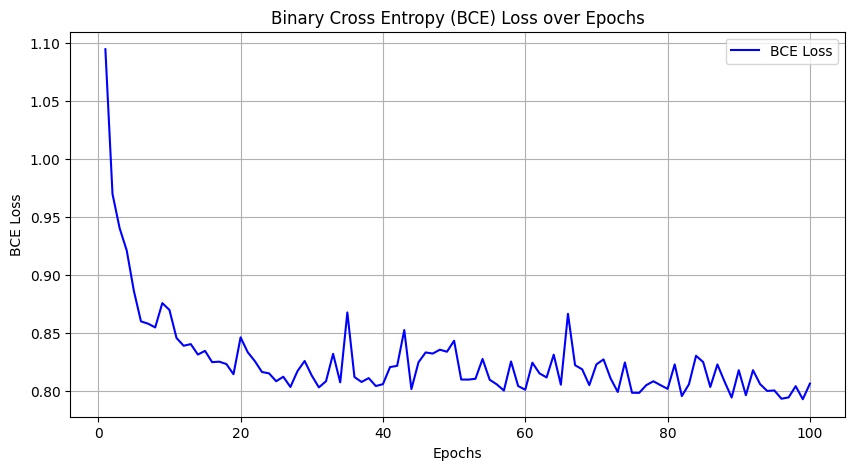

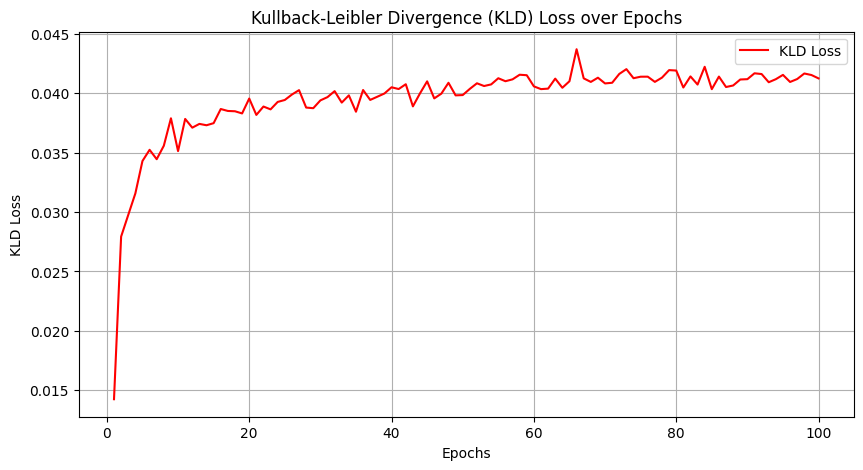

In [ ]:
import matplotlib.pyplot as plt

# BCE and KLD losses from the training
bce_losses4=[182.4171824394902, 161.65865683253807, 156.75273769716674, 153.54550344732743, 147.766551729999, 143.37243304675138, 143.0461014373393, 142.50531469417524, 145.99679275705844, 145.01881003078026, 140.98534702349312, 139.8774893072587, 140.11308810077136, 138.61170727693582, 139.14379670348347, 137.52518067178846, 137.5922297224214, 137.25483162795442, 135.79372299773783, 141.08177803136127, 138.9526987196524, 137.67626953125, 136.11271841314775, 135.91511352152764, 134.7895691304267, 135.4300727361365, 133.9635460769074, 136.2463534391379, 137.69474956657314, 135.59987543806244, 133.90685928924174, 134.78141707408278, 138.71514554566974, 134.61999898017208, 144.65732796584504, 135.38696163515502, 134.67969377734994, 135.2386752744264, 134.09950352922272, 134.36568779281424, 136.81479586830622, 136.99872733973248, 142.12733903715883, 133.6551157311548, 137.5085132454015, 138.9168748493436, 138.75599960134, 139.31029964398735, 139.01857583734053, 140.60101337674297, 135.03269224529024, 135.02031051056295, 135.1362392570399, 137.98143855227698, 134.99956522108633, 134.33672187901752, 133.4530568183223, 137.6226792154433, 134.09732664084132, 133.56431859656226, 137.44741357730913, 135.91449669946599, 135.33177194716055, 138.59620589244216, 134.29177817815466, 144.4617811758307, 137.08576318282115, 136.49415153793143, 134.2267067824738, 137.2058678156213, 137.91822187206412, 135.17169063906127, 133.24569547629054, 137.48204185389264, 133.1367060021509, 133.11476685729207, 134.21889795230913, 134.78353321703173, 134.2252960205078, 133.69379550595826, 137.20117061953002, 132.65450238577927, 134.34982125970382, 138.43931714794303, 137.53569079049026, 133.96438936643963, 137.1931644874283, 134.74834606315517, 132.4489065242719, 136.36436134048654, 132.78738490237464, 136.3718719482422, 134.37057630321647, 133.39175028740604, 133.46824394902097, 132.27767625639711, 132.46462780916238, 134.0764747329905, 132.20626290236848, 134.44397667993474]
kld_losses4= [2.374560114703601, 4.6553868462767785, 4.958685591251036, 5.260608147971237, 5.715585032595864, 5.872243760507318, 5.740710916398447, 5.929457489448257, 6.31425103054771, 5.854297770729548, 6.305359140227113, 6.182779058625426, 6.235692289811146, 6.216692972786819, 6.24596378471278, 6.444378581228135, 6.417198199260084, 6.412923716291597, 6.3823183035548725, 6.591245971148527, 6.3616295826585985, 6.479129519643663, 6.439531012426449, 6.543734538404247, 6.571169358265551, 6.647347033778323, 6.7092449634890015, 6.464818513846096, 6.4558839979051035, 6.565423814556267, 6.6113644672345515, 6.694923871680151, 6.534311511848546, 6.635894654672357, 6.406500991386704, 6.710952686358102, 6.571910586538194, 6.616781120058857, 6.662080988099303, 6.749317084686665, 6.724536503417583, 6.792116768752472, 6.481343263312231, 6.664292045786411, 6.832552976246122, 6.593345630018017, 6.660284018214745, 6.812251797205286, 6.635765763777721, 6.640122238593765, 6.7270211388793175, 6.805158717722833, 6.766862434676931, 6.78966661042805, 6.876079124740407, 6.8342199385920654, 6.860390349279476, 6.925293970711624, 6.918375594706475, 6.761970513983618, 6.723439313188384, 6.73023531104945, 6.870814154419718, 6.742445136927351, 6.833931584901448, 7.282949538170537, 6.874371818349331, 6.824435143531123, 6.883540714843364, 6.803213825708704, 6.812608851662165, 6.93656132492838, 7.003645800337007, 6.876430988311768, 6.89746881436698, 6.89806352084196, 6.824907785729517, 6.884505066690566, 6.989957405042045, 6.984048565731773, 6.74593345424797, 6.901806439025493, 6.787467914291575, 7.036574556857725, 6.722700535496579, 6.8991855488547795, 6.752960947495472, 6.774383991579466, 6.858445348618906, 6.86284746097613, 6.945402785192562, 6.934693107122107, 6.819862655446499, 6.862837477575375, 6.923073340065872, 6.823775738100462, 6.8650062235095834, 6.942684909965418, 6.921179354945315, 6.873758376399173]
bce_losses4_multiplied = [x * 0.006 for x in bce_losses4]
kld_losses4_multiplied = [x * 0.006 for x in kld_losses4]

epochs = range(1, len(bce_losses4_multiplied) + 1)

# Plotting BCE loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, bce_losses4_multiplied, label='BCE Loss', color='blue')
plt.title('Binary Cross Entropy (BCE) Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)
plt.show()
epochs = range(1, len(kld_losses4_multiplied) + 1)

# Plotting KLD loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, kld_losses4_multiplied, label='KLD Loss', color='red')
plt.title('Kullback-Leibler Divergence (KLD) Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('KLD Loss')
plt.legend()
plt.grid(True)
plt.show()

DEPTH 5 , EPOCH 100

In [ ]:
print("BCE_losses")
print(bce_losses)
print("KDL losses")
print(kld_losses)

BCE_losses
[172.0509942935992, 177.9433504901355, 177.8287979319126, 172.84993599034564, 176.24770036528383, 170.7890145989913, 168.37372424934483, 167.94871520996094, 164.49640182301968, 164.02221505853194, 172.79662390600276, 168.1332980771608, 167.52845493751235, 168.0417163704015, 168.29689837105667, 176.35177148746538, 170.12245564521115, 167.56214074243474, 166.07678782789014, 163.1470306010186, 165.33730615543413, 165.2868213895001, 162.0044538280632, 161.05697071703173, 160.32230019871193, 158.84532030322885, 158.81139383436758, 159.14837105666535, 157.05432689039014, 158.39110671417623, 160.272985530805, 170.47045067895817, 166.61111199101316, 159.15547489214546, 161.0180490228194, 161.99085670181466, 159.02268325226217, 160.93010122564775, 158.57317516471767, 158.6398386894902, 164.09774278085442, 163.9806817935992, 169.50199156169649, 164.82958598076542, 164.1640652040892, 163.5136691709108, 161.88421746748912, 165.0335882645619, 165.67715550676178, 162.5669094037406, 164.02

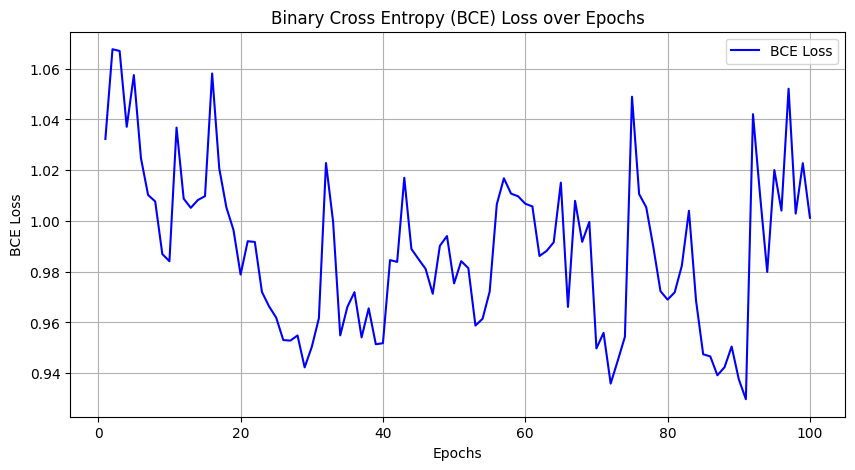

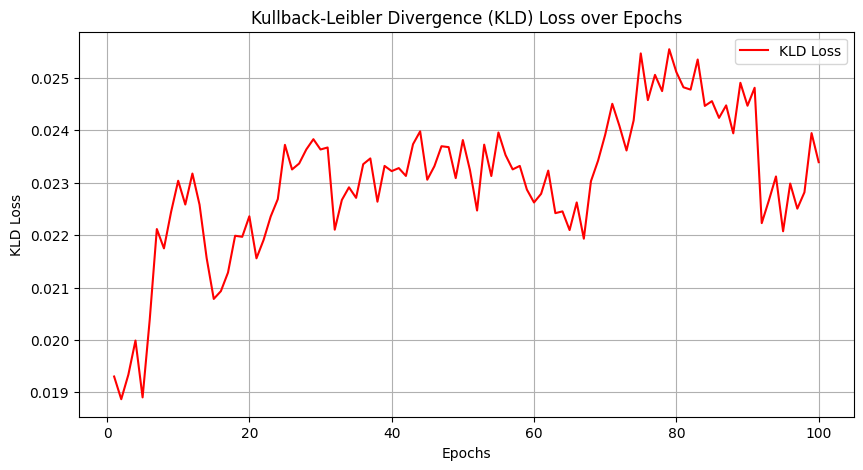

In [ ]:
import matplotlib.pyplot as plt

# BCE and KLD losses from the training
bce_losses5=[172.0509942935992, 177.9433504901355, 177.8287979319126, 172.84993599034564, 176.24770036528383, 170.7890145989913, 168.37372424934483, 167.94871520996094, 164.49640182301968, 164.02221505853194, 172.79662390600276, 168.1332980771608, 167.52845493751235, 168.0417163704015, 168.29689837105667, 176.35177148746538, 170.12245564521115, 167.56214074243474, 166.07678782789014, 163.1470306010186, 165.33730615543413, 165.2868213895001, 162.0044538280632, 161.05697071703173, 160.32230019871193, 158.84532030322885, 158.81139383436758, 159.14837105666535, 157.05432689039014, 158.39110671417623, 160.272985530805, 170.47045067895817, 166.61111199101316, 159.15547489214546, 161.0180490228194, 161.99085670181466, 159.02268325226217, 160.93010122564775, 158.57317516471767, 158.6398386894902, 164.09774278085442, 163.9806817935992, 169.50199156169649, 164.82958598076542, 164.1640652040892, 163.5136691709108, 161.88421746748912, 165.0335882645619, 165.67715550676178, 162.5669094037406, 164.0274577080449, 163.56993315491496, 159.7999692506428, 160.2432834287233, 162.0296636653852, 167.76168089275117, 169.46998229207873, 168.46338528017455, 168.2847724624827, 167.79980449435078, 167.61970925632912, 164.3664915833292, 164.70042322858978, 165.26961314527296, 169.18300522430033, 161.02334961710096, 167.98647549786145, 165.2962146227873, 166.60242549075355, 158.29821468304985, 159.31992137281202, 155.98945173432554, 157.49839763399922, 159.05870539025415, 174.8234809199466, 168.4293158808841, 167.56544224219985, 164.9509783394729, 162.05644148814528, 161.50157976754105, 161.98262390909315, 163.725716892677, 167.3364885547493, 161.4262386273734, 157.9137839788123, 157.77287331110315, 156.53510854214053, 157.0625573653209, 158.42176818847656, 156.28235558618474, 154.96213502521758, 173.67844419841524, 168.3275888177413, 163.31868541089796, 170.00870851927166, 167.34942762157584, 175.34922867787034, 167.14845256563984, 170.45944600165646, 166.87890625]
kld_losses5= [3.2171018183985844, 3.1448895840705196, 3.2229166000704224, 3.331473413901993, 3.15070885042601, 3.397412903701203, 3.686055648175976, 3.624586431286003, 3.7401256138765357, 3.839632321007644, 3.764076483400562, 3.8625727273240873, 3.7636085401607464, 3.593834671793105, 3.463847591907163, 3.488546099843858, 3.5476833295218553, 3.664703441571586, 3.6613947349258615, 3.72663725176944, 3.592979038817973, 3.651312936710406, 3.725968360900879, 3.781295863887932, 3.953853987440278, 3.875574688368206, 3.8944614869129808, 3.9390476232842553, 3.971772196926648, 3.9390619404708285, 3.9454552946211416, 3.68407092818731, 3.778516838822184, 3.818769590764106, 3.7852758606777916, 3.892261145990106, 3.9106497311893897, 3.772941547104075, 3.886856281304661, 3.8702727360061453, 3.879903244066842, 3.8549291755579693, 3.9558698648138892, 3.996761255626437, 3.8429424098775358, 3.8857791423797607, 3.9494104536273813, 3.946578762199305, 3.848030250283736, 3.969105584711968, 3.8734300891055335, 3.7450363213502906, 3.9544169510467144, 3.8546787606009953, 3.993107958684994, 3.9213208699528175, 3.875763865965831, 3.886867517157446, 3.811542462699021, 3.770563258400446, 3.7981529507455947, 3.871932446202145, 3.7366136267215393, 3.742266054394879, 3.6827831479567514, 3.7707229867766174, 3.6554894477506226, 3.8382151489016376, 3.9035532263260855, 3.9858668755881395, 4.084381079371972, 4.014252270324321, 3.935903639733037, 4.031495715998396, 4.244570611398431, 4.096049580392958, 4.176380362691758, 4.124758379368842, 4.257917555072639, 4.185393985313706, 4.136870767496809, 4.129475777662253, 4.225245958642114, 4.077645280693151, 4.092835685874842, 4.039581410492523, 4.079304619680477, 3.990421412866327, 4.151124525673782, 4.078190571145166, 4.135335668732848, 3.704836105998558, 3.776947419854659, 3.8533107057402405, 3.6790506900111333, 3.830798167216627, 3.750958355167244, 3.8029730470874643, 3.9912171092214463, 3.8987084249906903]
bce_losses5_multiplied = [x * 0.006 for x in bce_losses5]
kld_losses5_multiplied = [x * 0.006 for x in kld_losses5]

epochs = range(1, len(bce_losses5_multiplied) + 1)

# Plotting BCE loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, bce_losses5_multiplied, label='BCE Loss', color='blue')
plt.title('Binary Cross Entropy (BCE) Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)
plt.show()
epochs = range(1, len(kld_losses5_multiplied) + 1)

# Plotting KLD loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, kld_losses5_multiplied, label='KLD Loss', color='red')
plt.title('Kullback-Leibler Divergence (KLD) Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('KLD Loss')
plt.legend()
plt.grid(True)
plt.show()

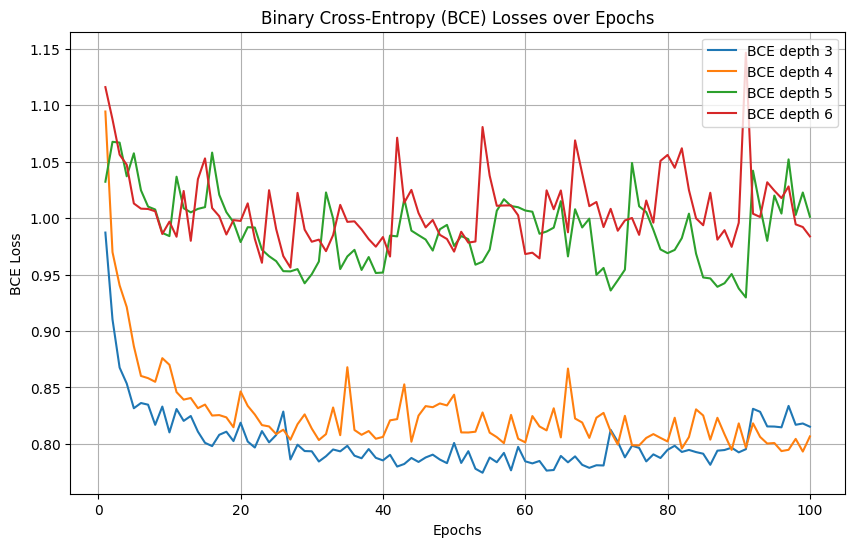

In [ ]:
import matplotlib.pyplot as plt

# Assuming bce_losses3, bce_losses4, bce_losses5, and bce_losses6 are lists or arrays containing the BCE losses over 100 epochs

epochs = list(range(1, 101))  # Assuming 100 epochs

plt.figure(figsize=(10, 6))

# Plot BCE losses for each set
plt.plot(epochs, bce_losses3_multiplied, label='BCE depth 3')
plt.plot(epochs, bce_losses4_multiplied, label='BCE depth 4')
plt.plot(epochs, bce_losses5_multiplied, label='BCE depth 5')
plt.plot(epochs, bce_losses6_multiplied, label='BCE depth 6')

plt.title('Binary Cross-Entropy (BCE) Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.legend(loc='upper right')  # Adjusted legend position
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Assuming bce_losses3, bce_losses4, bce_losses5, and bce_losses6 are lists or arrays containing the BCE losses over 100 epochs

# Convert lists to NumPy arrays for easier computation
bce_losses3 = np.array(bce_losses3_multiplied)
bce_losses4 = np.array(bce_losses4_multiplied)
bce_losses5 = np.array(bce_losses5_multiplied)
bce_losses6 = np.array(bce_losses6_multiplied)

# Calculate mean and std for each BCE vector
mean_bce3 = np.mean(bce_losses3)
std_bce3 = np.std(bce_losses3)

mean_bce4 = np.mean(bce_losses4)
std_bce4 = np.std(bce_losses4)

mean_bce5 = np.mean(bce_losses5)
std_bce5 = np.std(bce_losses5)

mean_bce6 = np.mean(bce_losses6)
std_bce6 = np.std(bce_losses6)

# Print the results
print("Mean BCE Loss and Std for bce_losses3:", mean_bce3, std_bce3)
print("Mean BCE Loss and Std for bce_losses4:", mean_bce4, std_bce4)
print("Mean BCE Loss and Std for bce_losses5:", mean_bce5, std_bce5)
print("Mean BCE Loss and Std for bce_losses6:", mean_bce6, std_bce6)


Mean BCE Loss and Std for bce_losses3: 0.8023282853254489 0.028009631441833927
Mean BCE Loss and Std for bce_losses4: 0.8265988916653019 0.03941136588860983
Mean BCE Loss and Std for bce_losses5: 0.9886638504685028 0.03143461904334326
Mean BCE Loss and Std for bce_losses6: 1.0074283477281014 0.03245908653570112


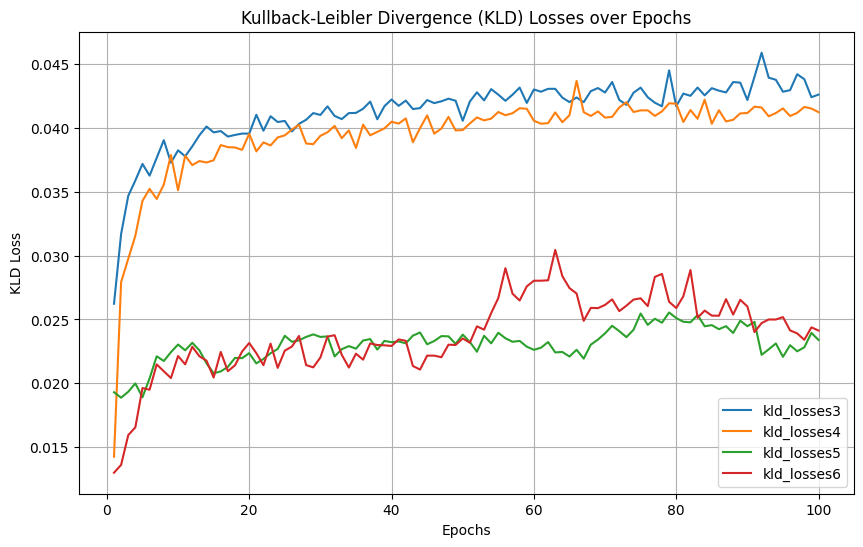

In [ ]:
import matplotlib.pyplot as plt

# Assuming kld_losses3, kld_losses4, kld_losses5, and kld_losses6 are lists or arrays containing the KLD losses over 100 epochs

epochs = list(range(1, 101))  # Assuming 100 epochs

plt.figure(figsize=(10, 6))

# Plot KLD losses for each set
plt.plot(epochs, kld_losses3_multiplied, label='kld_losses3')
plt.plot(epochs, kld_losses4_multiplied, label='kld_losses4')
plt.plot(epochs, kld_losses5_multiplied, label='kld_losses5')
plt.plot(epochs, kld_losses6_multiplied, label='kld_losses6')

plt.title('Kullback-Leibler Divergence (KLD) Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('KLD Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Assuming kld_losses3_multiplied, kld_losses4_multiplied, kld_losses5_multiplied, and kld_losses6_multiplied
# are lists or arrays containing the KLD losses over 100 epochs

# Convert lists to NumPy arrays for easier computation
kld_losses3 = np.array(kld_losses3_multiplied)
kld_losses4 = np.array(kld_losses4_multiplied)
kld_losses5 = np.array(kld_losses5_multiplied)
kld_losses6 = np.array(kld_losses6_multiplied)

# Calculate mean and std for each KLD vector
mean_kld3 = np.mean(kld_losses3)
std_kld3 = np.std(kld_losses3)

mean_kld4 = np.mean(kld_losses4)
std_kld4 = np.std(kld_losses4)

mean_kld5 = np.mean(kld_losses5)
std_kld5 = np.std(kld_losses5)

mean_kld6 = np.mean(kld_losses6)
std_kld6 = np.std(kld_losses6)

# Print the results
print("Mean KLD Loss and Std for kld_losses3:", mean_kld3, std_kld3)
print("Mean KLD Loss and Std for kld_losses4:", mean_kld4, std_kld4)
print("Mean KLD Loss and Std for kld_losses5:", mean_kld5, std_kld5)
print("Mean KLD Loss and Std for kld_losses6:", mean_kld6, std_kld6)


Mean KLD Loss and Std for kld_losses3: 0.041291810676659206 0.002629905337866904
Mean KLD Loss and Std for kld_losses4: 0.03945456559470937 0.0035184961628532043
Mean KLD Loss and Std for kld_losses5: 0.023036386507734465 0.0013390384355103058
Mean KLD Loss and Std for kld_losses6: 0.023832359773146957 0.0030170367137716523




```
depth = 6
```



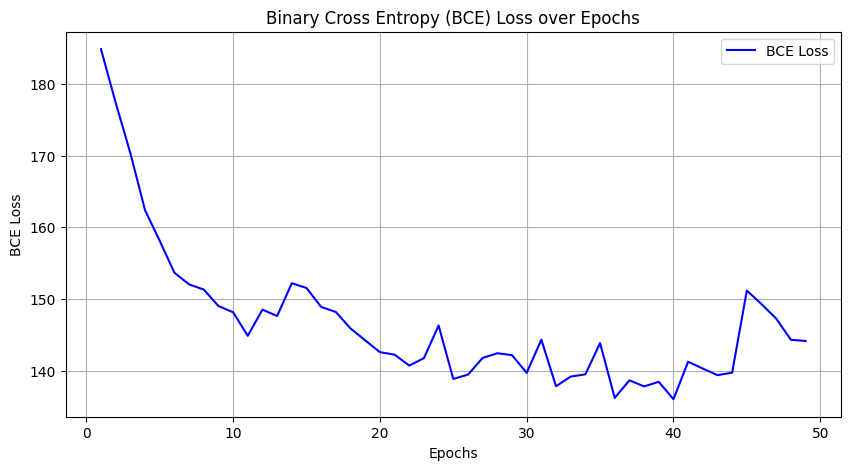

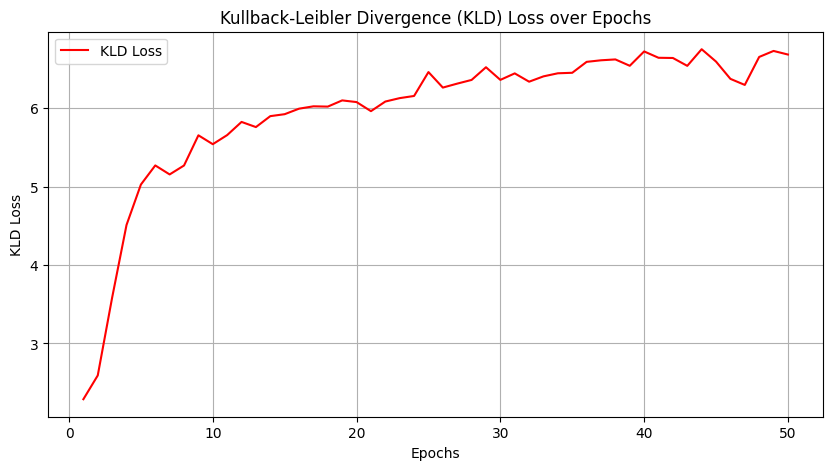

In [ ]:
import matplotlib.pyplot as plt

# BCE and KLD losses from the training
bce_losses = [184.8150, 177.3548, 170.3315, 162.3803, 158.1104, 153.6665, 152.0381, 151.3147, 149.0255, 148.1506,
              144.8705, 148.5187, 147.6269, 152.1995, 151.5345, 148.8952, 148.1877, 145.8954, 144.2419, 142.5884,
              142.2438, 140.7191, 141.7545, 146.3064, 138.8600, 139.4542, 141.7838, 142.4367, 142.1755, 139.7005,
              144.3290, 137.8400, 139.1835, 139.5014, 143.8474, 136.2186, 138.6630, 137.8153, 138.4556, 136.0305,
              141.2529, 140.3034, 139.3819, 139.7386, 151.1731, 149.2850, 147.2704, 144.3181, 144.1521]

kld_losses = [2.2885, 2.5918, 3.5838, 4.5099, 5.0255, 5.2693, 5.1546, 5.2686, 5.6534, 5.5402, 5.6562, 5.8240, 5.7584,
              5.8978, 5.9227, 5.9930, 6.0230, 6.0195, 6.0985, 6.0771, 5.9614, 6.0839, 6.1275, 6.1550, 6.4599, 6.2619,
              6.3124, 6.3595, 6.5213, 6.3601, 6.4429, 6.3370, 6.4050, 6.4442, 6.4506, 6.5899, 6.6099, 6.6209, 6.5398,
              6.7228, 6.6419, 6.6392, 6.5389, 6.7510, 6.5933, 6.3731, 6.2957, 6.6524, 6.7291, 6.6832]

epochs = range(1, len(bce_losses) + 1)

# Plotting BCE loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, bce_losses, label='BCE Loss', color='blue')
plt.title('Binary Cross Entropy (BCE) Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)
plt.show()
epochs = range(1, len(kld_losses) + 1)

# Plotting KLD loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, kld_losses, label='KLD Loss', color='red')
plt.title('Kullback-Leibler Divergence (KLD) Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('KLD Loss')
plt.legend()
plt.grid(True)
plt.show()


depth = 5

49
50


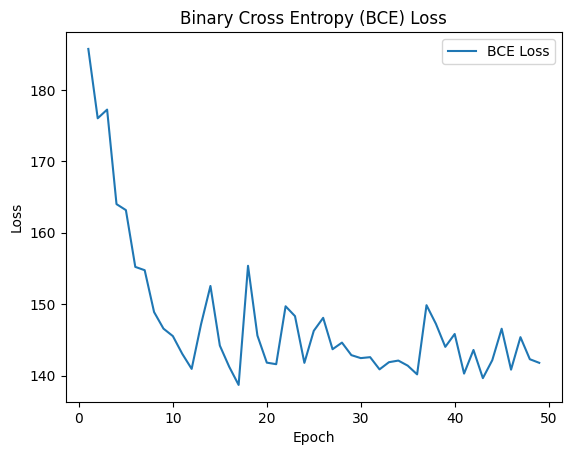

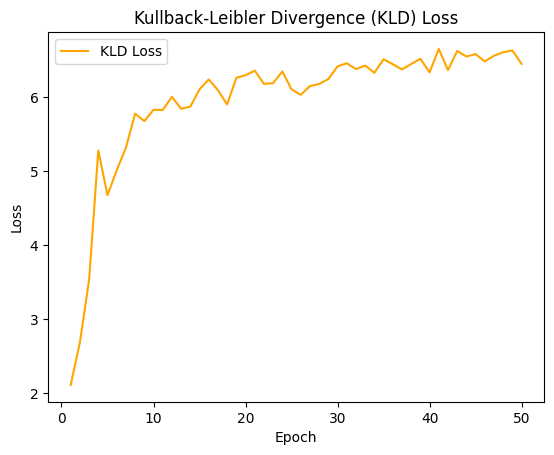

In [ ]:
import matplotlib.pyplot as plt

# BCE loss values for each epoch
bce_losses = [185.7232, 176.0122, 177.2283, 163.9966, 163.1568, 155.2076, 154.7442, 148.8847, 146.5629, 145.5176,
              143.0363, 140.9278, 147.1792, 152.5386, 144.1928, 141.2172, 138.6833, 155.3621, 145.5946, 141.8035,
              141.5839, 149.6951, 148.3144, 141.7730, 146.2576, 148.0777, 143.6810, 144.6077, 142.8538, 142.4373,
              142.5683, 140.8601, 141.8628, 142.0922, 141.3817, 140.1602, 149.8453, 147.2393, 144.0119, 145.8152,
              140.2699, 143.5782, 139.6334, 142.1397, 146.5501, 140.8219, 145.3704, 142.2799, 141.7764]

# KLD loss values for each epoch
kld_losses = [2.1097, 2.6853, 3.5293, 5.2792, 4.6735, 5.0112, 5.3158, 5.7773, 5.6752, 5.8286,
              5.8260, 6.0035, 5.8425, 5.8721, 6.1049, 6.2397, 6.0941, 5.9014, 6.2611, 6.2961,
              6.3587, 6.1789, 6.1894, 6.3466, 6.1042, 6.0320, 6.1497, 6.1775, 6.2445, 6.4160,
              6.4582, 6.3792, 6.4267, 6.3290, 6.5121, 6.4456, 6.3752, 6.4480, 6.5189, 6.3347,
              6.6518, 6.3652, 6.6238, 6.5488, 6.5822, 6.4827, 6.5605, 6.6066, 6.6306, 6.4494]
print(len(bce_losses))
print(len(kld_losses))
# Epochs
epochs = range(1, len(bce_losses) + 1)

# Plotting BCE loss
plt.plot(epochs, bce_losses, label='BCE Loss')
plt.title('Binary Cross Entropy (BCE) Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
epochs = range(1, len(kld_losses) + 1)

# Plotting KLD loss
plt.plot(epochs, kld_losses, label='KLD Loss', color='orange')
plt.title('Kullback-Leibler Divergence (KLD) Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




```
increasing depth 4
```



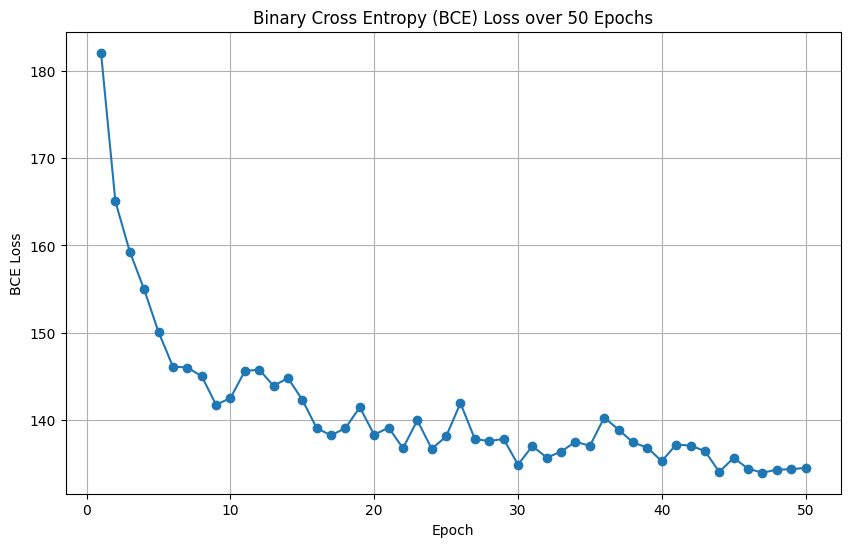

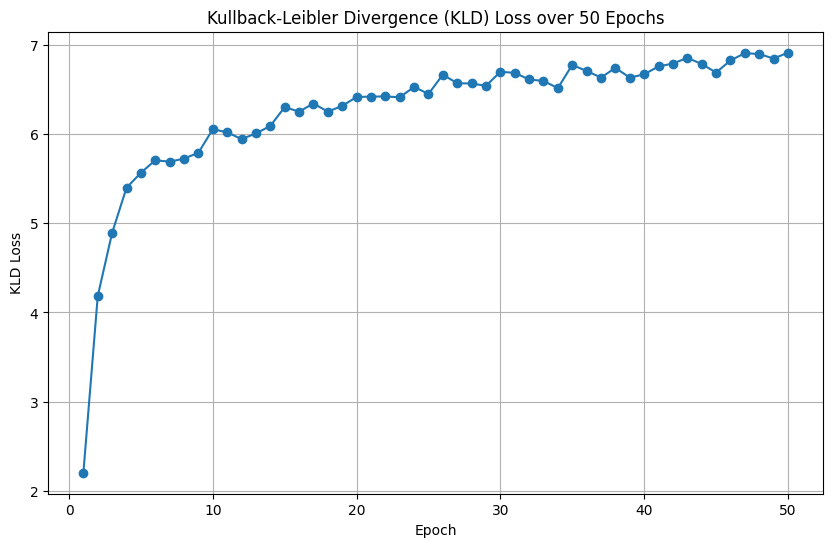

In [ ]:
import matplotlib.pyplot as plt

# BCE and KLD losses over 50 epochs
bce_losses = [182.1130, 165.0559, 159.3014, 154.9613, 150.0688, 146.1124, 145.9957, 145.0102, 141.7298, 142.4853,
              145.5846, 145.7615, 143.8982, 144.7848, 142.3066, 139.0402, 138.2162, 139.0522, 141.4371, 138.2779,
              139.1080, 136.7427, 139.9332, 136.6695, 138.0854, 141.9140, 137.7863, 137.5707, 137.8012, 134.8568,
              136.9849, 135.6712, 136.3423, 137.4924, 137.0107, 140.2575, 138.8651, 137.3991, 136.8042, 135.2482,
              137.1636, 137.0414, 136.4190, 134.0186, 135.6364, 134.3963, 133.9286, 134.2827, 134.3288, 134.4859]

kld_losses = [2.2035, 4.1843, 4.8935, 5.3987, 5.5664, 5.7071, 5.6908, 5.7255, 5.7908, 6.0551,
              6.0200, 5.9445, 6.0075, 6.0917, 6.3025, 6.2524, 6.3426, 6.2528, 6.3163, 6.4164,
              6.4207, 6.4226, 6.4133, 6.5295, 6.4504, 6.6669, 6.5704, 6.5677, 6.5413, 6.6992,
              6.6870, 6.6127, 6.5962, 6.5163, 6.7763, 6.7076, 6.6345, 6.7427, 6.6336, 6.6703,
              6.7593, 6.7911, 6.8545, 6.7873, 6.6905, 6.8255, 6.9074, 6.8985, 6.8473, 6.9127]

# Plot BCE loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), bce_losses, marker='o', linestyle='-')
plt.title('Binary Cross Entropy (BCE) Loss over 50 Epochs')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.grid(True)
plt.show()

# Plot KLD loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), kld_losses, marker='o', linestyle='-')
plt.title('Kullback-Leibler Divergence (KLD) Loss over 50 Epochs')
plt.xlabel('Epoch')
plt.ylabel('KLD Loss')
plt.grid(True)
plt.show()



depth 3

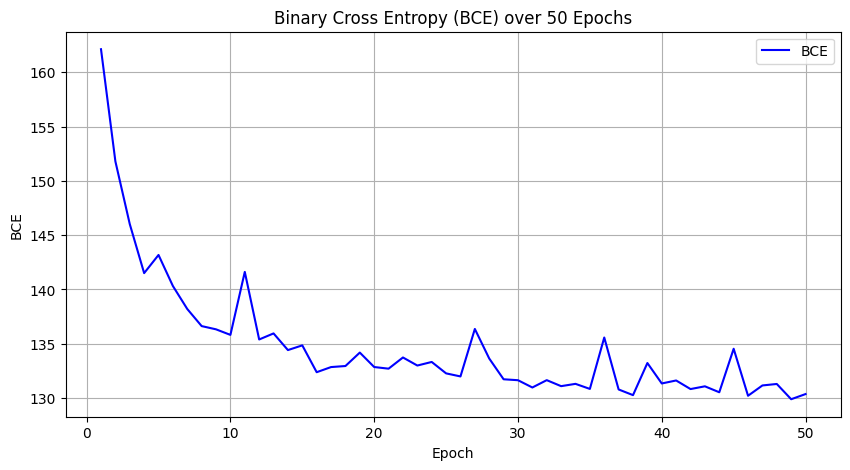

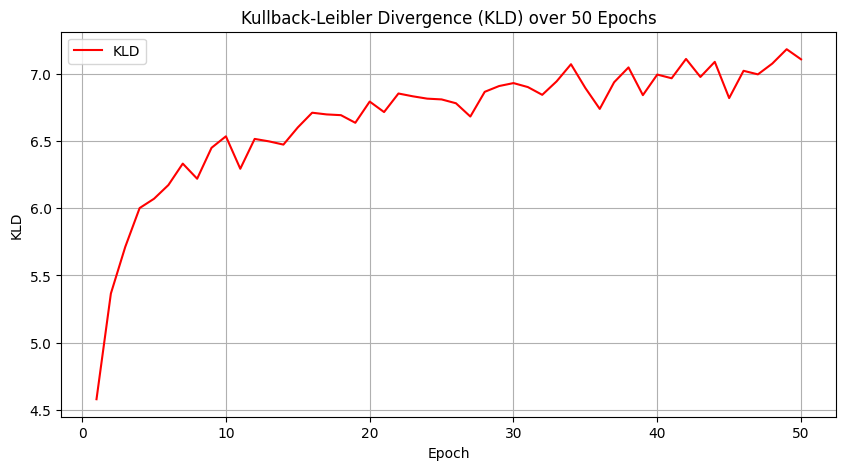

In [ ]:
import matplotlib.pyplot as plt

# BCE and KLD values extracted from the logs
bce_values = [162.1241, 151.7956, 146.0184, 141.4984, 143.1720, 140.3108, 138.1929, 136.6190, 136.3206, 135.8085,
              141.6112, 135.3865, 135.9442, 134.4098, 134.8440, 132.3716, 132.8447, 132.9409, 134.1786, 132.8481,
              132.6966, 133.7278, 132.9856, 133.3154, 132.2645, 131.9813, 136.3551, 133.6327, 131.7200, 131.6333,
              130.9633, 131.6389, 131.0863, 131.2986, 130.8319, 135.5673, 130.7811, 130.2595, 133.2169, 131.3345,
              131.6089, 130.8186, 131.0715, 130.5234, 134.5312, 130.2015, 131.1511, 131.2878, 129.8825, 130.3575]

kld_values = [4.5782, 5.3652, 5.7126, 6.0016, 6.0708, 6.1730, 6.3325, 6.2199, 6.4502, 6.5357,
              6.2941, 6.5164, 6.4980, 6.4740, 6.6020, 6.7115, 6.6988, 6.6932, 6.6365, 6.7944,
              6.7163, 6.8545, 6.8336, 6.8162, 6.8105, 6.7818, 6.6830, 6.8670, 6.9101, 6.9320,
              6.9024, 6.8446, 6.9449, 7.0724, 6.8953, 6.7398, 6.9383, 7.0487, 6.8423, 6.9955,
              6.9680, 7.1119, 6.9777, 7.0903, 6.8203, 7.0235, 6.9970, 7.0773, 7.1842, 7.1090]

# Number of epochs
epochs = range(1, 51)

# Plot BCE values
plt.figure(figsize=(10, 5))
plt.plot(epochs, bce_values, label='BCE', color='blue')
plt.title('Binary Cross Entropy (BCE) over 50 Epochs')
plt.xlabel('Epoch')
plt.ylabel('BCE')
plt.legend()
plt.grid(True)
plt.show()

# Plot KLD values
plt.figure(figsize=(10, 5))
plt.plot(epochs, kld_values, label='KLD', color='red')
plt.title('Kullback-Leibler Divergence (KLD) over 50 Epochs')
plt.xlabel('Epoch')
plt.ylabel('KLD')
plt.legend()
plt.grid(True)
plt.show()



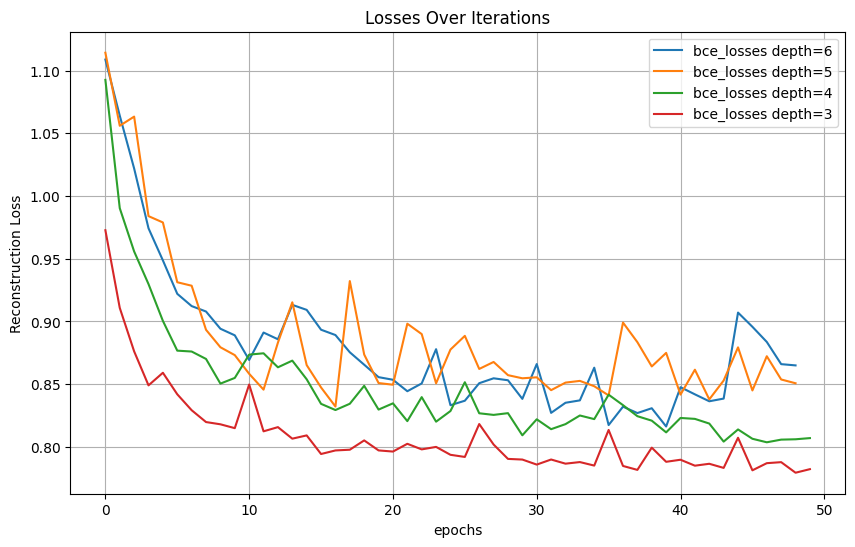

In [ ]:
import matplotlib.pyplot as plt

# Define your data
bce_losses6 = [184.8150, 177.3548, 170.3315, 162.3803, 158.1104, 153.6665, 152.0381, 151.3147, 149.0255, 148.1506,
              144.8705, 148.5187, 147.6269, 152.1995, 151.5345, 148.8952, 148.1877, 145.8954, 144.2419, 142.5884,
              142.2438, 140.7191, 141.7545, 146.3064, 138.8600, 139.4542, 141.7838, 142.4367, 142.1755, 139.7005,
              144.3290, 137.8400, 139.1835, 139.5014, 143.8474, 136.2186, 138.6630, 137.8153, 138.4556, 136.0305,
              141.2529, 140.3034, 139.3819, 139.7386, 151.1731, 149.2850, 147.2704, 144.3181, 144.1521]

bce_losses5 = [185.7232, 176.0122, 177.2283, 163.9966, 163.1568, 155.2076, 154.7442, 148.8847, 146.5629, 145.5176,
              143.0363, 140.9278, 147.1792, 152.5386, 144.1928, 141.2172, 138.6833, 155.3621, 145.5946, 141.8035,
              141.5839, 149.6951, 148.3144, 141.7730, 146.2576, 148.0777, 143.6810, 144.6077, 142.8538, 142.4373,
              142.5683, 140.8601, 141.8628, 142.0922, 141.3817, 140.1602, 149.8453, 147.2393, 144.0119, 145.8152,
              140.2699, 143.5782, 139.6334, 142.1397, 146.5501, 140.8219, 145.3704, 142.2799, 141.7764]

bce_losses4 = [182.1130, 165.0559, 159.3014, 154.9613, 150.0688, 146.1124, 145.9957, 145.0102, 141.7298, 142.4853,
              145.5846, 145.7615, 143.8982, 144.7848, 142.3066, 139.0402, 138.2162, 139.0522, 141.4371, 138.2779,
              139.1080, 136.7427, 139.9332, 136.6695, 138.0854, 141.9140, 137.7863, 137.5707, 137.8012, 134.8568,
              136.9849, 135.6712, 136.3423, 137.4924, 137.0107, 140.2575, 138.8651, 137.3991, 136.8042, 135.2482,
              137.1636, 137.0414, 136.4190, 134.0186, 135.6364, 134.3963, 133.9286, 134.2827, 134.3288, 134.4859]

bce_losses3 = [162.1241, 151.7956, 146.0184, 141.4984, 143.1720, 140.3108, 138.1929, 136.6190, 136.3206, 135.8085,
              141.6112, 135.3865, 135.9442, 134.4098, 134.8440, 132.3716, 132.8447, 132.9409, 134.1786, 132.8481,
              132.6966, 133.7278, 132.9856, 133.3154, 132.2645, 131.9813, 136.3551, 133.6327, 131.7200, 131.6333,
              130.9633, 131.6389, 131.0863, 131.2986, 130.8319, 135.5673, 130.7811, 130.2595, 133.2169, 131.3345,
              131.6089, 130.8186, 131.0715, 130.5234, 134.5312, 130.2015, 131.1511, 131.2878, 129.8825, 130.3575]

bce_losses6_multiplied = [x * 0.006 for x in bce_losses6]
bce_losses5_multiplied = [x * 0.006 for x in bce_losses5]
bce_losses4_multiplied = [x * 0.006 for x in bce_losses4]
bce_losses3_multiplied = [x * 0.006 for x in bce_losses3]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(bce_losses6_multiplied, label='bce_losses depth=6')
plt.plot(bce_losses5_multiplied, label='bce_losses depth=5')
plt.plot(bce_losses4_multiplied, label='bce_losses depth=4')
plt.plot(bce_losses3_multiplied, label='bce_losses depth=3')
plt.xlabel('epochs')
plt.ylabel('Reconstruction Loss')
plt.title('Losses Over Iterations')
plt.legend()
plt.grid(True)
plt.show()


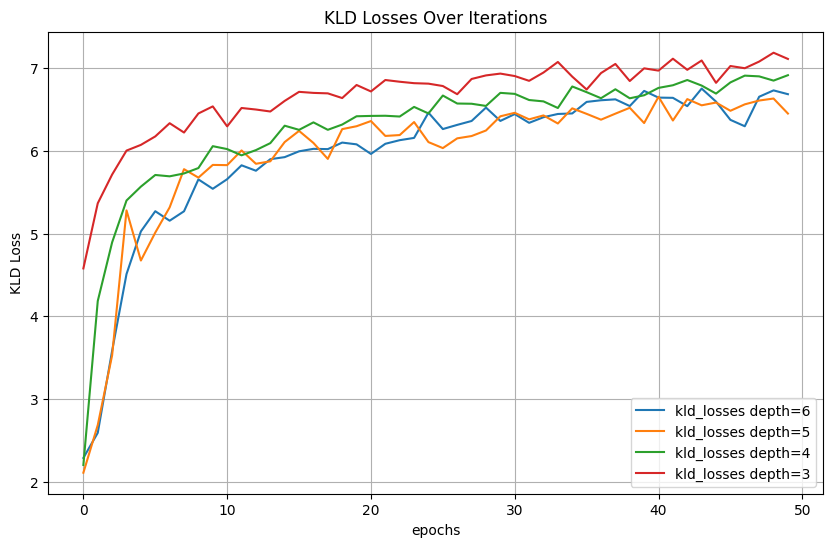

In [ ]:
import matplotlib.pyplot as plt

# Define your data
kld_losses6 = [2.2885, 2.5918, 3.5838, 4.5099, 5.0255, 5.2693, 5.1546, 5.2686, 5.6534, 5.5402, 5.6562, 5.8240, 5.7584,
              5.8978, 5.9227, 5.9930, 6.0230, 6.0195, 6.0985, 6.0771, 5.9614, 6.0839, 6.1275, 6.1550, 6.4599, 6.2619,
              6.3124, 6.3595, 6.5213, 6.3601, 6.4429, 6.3370, 6.4050, 6.4442, 6.4506, 6.5899, 6.6099, 6.6209, 6.5398,
              6.7228, 6.6419, 6.6392, 6.5389, 6.7510, 6.5933, 6.3731, 6.2957, 6.6524, 6.7291, 6.6832]

kld_losses5 = [2.1097, 2.6853, 3.5293, 5.2792, 4.6735, 5.0112, 5.3158, 5.7773, 5.6752, 5.8286,
              5.8260, 6.0035, 5.8425, 5.8721, 6.1049, 6.2397, 6.0941, 5.9014, 6.2611, 6.2961,
              6.3587, 6.1789, 6.1894, 6.3466, 6.1042, 6.0320, 6.1497, 6.1775, 6.2445, 6.4160,
              6.4582, 6.3792, 6.4267, 6.3290, 6.5121, 6.4456, 6.3752, 6.4480, 6.5189, 6.3347,
              6.6518, 6.3652, 6.6238, 6.5488, 6.5822, 6.4827, 6.5605, 6.6066, 6.6306, 6.4494]

kld_losses4 = [2.2035, 4.1843, 4.8935, 5.3987, 5.5664, 5.7071, 5.6908, 5.7255, 5.7908, 6.0551,
              6.0200, 5.9445, 6.0075, 6.0917, 6.3025, 6.2524, 6.3426, 6.2528, 6.3163, 6.4164,
              6.4207, 6.4226, 6.4133, 6.5295, 6.4504, 6.6669, 6.5704, 6.5677, 6.5413, 6.6992,
              6.6870, 6.6127, 6.5962, 6.5163, 6.7763, 6.7076, 6.6345, 6.7427, 6.6336, 6.6703,
              6.7593, 6.7911, 6.8545, 6.7873, 6.6905, 6.8255, 6.9074, 6.8985, 6.8473, 6.9127]

kld_losses3 = [4.5782, 5.3652, 5.7126, 6.0016, 6.0708, 6.1730, 6.3325, 6.2199, 6.4502, 6.5357,
              6.2941, 6.5164, 6.4980, 6.4740, 6.6020, 6.7115, 6.6988, 6.6932, 6.6365, 6.7944,
              6.7163, 6.8545, 6.8336, 6.8162, 6.8105, 6.7818, 6.6830, 6.8670, 6.9101, 6.9320,
              6.9024, 6.8446, 6.9449, 7.0724, 6.8953, 6.7398, 6.9383, 7.0487, 6.8423, 6.9955,
              6.9680, 7.1119, 6.9777, 7.0903, 6.8203, 7.0235, 6.9970, 7.0773, 7.1842, 7.1090]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(kld_losses6, label='kld_losses depth=6')
plt.plot(kld_losses5, label='kld_losses depth=5')
plt.plot(kld_losses4, label='kld_losses depth=4')
plt.plot(kld_losses3, label='kld_losses depth=3')
plt.xlabel('epochs')
plt.ylabel('KLD Loss')
plt.title('KLD Losses Over Iterations')
plt.legend()
plt.grid(True)
plt.show()
